In [1]:
import functools
import itertools
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import interpolate
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn import datasets
from sklearn import metrics as skm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [2]:
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [3]:
import knn_from_scratch as knsc

In [4]:
### get data
X, y = datasets.make_blobs(
    n_samples=100,
    centers=3,
    n_features=2,
    random_state=0
)


In [6]:
### for many splits and k see how well classifier performs
grid_params_basis = [
    [0.1, 0.2, 0.5, 0.8, 0.9], # test frac
    list(range(1, 30 + 1)) # k (be mindfull of k for given test fracs)
]

grid_params, test_scores, roc_auc_curves = knsc.many_knn_runs(
    X,
    y,
    grid_params_basis=grid_params_basis
)
acc, precision, recall = test_scores
raucs, fprs_interp, tprs_interp = roc_auc_curves
del test_scores, roc_auc_curves

C:\Users\the_s\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\the_s\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\the_s\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\the_s\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedM

C:\Users\the_s\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\the_s\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\the_s\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\the_s\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedM

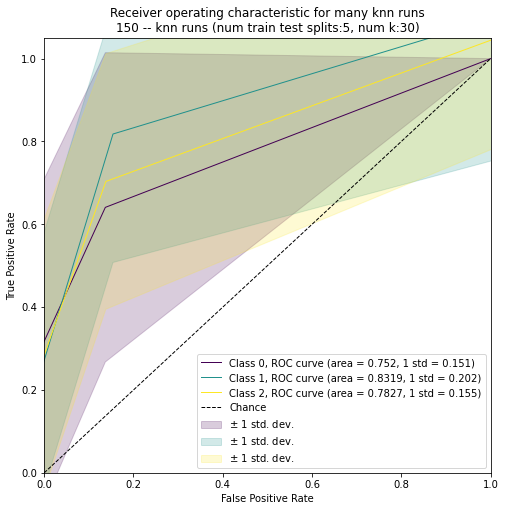

In [8]:
# plot auc roc curves for many knn runs
mean_auc = np.mean(raucs, axis=0)
std_auc = np.std(raucs, axis=0)
mean_fpr = np.mean(fprs_interp, axis=1).T # shape (n_threhes, n_classes)
mean_tpr = np.mean(tprs_interp, axis=1).T
std_tpr = np.std(tprs_interp, axis=1).T
knsc.plot_multiclass_auc_roc_curves_many(
    mean_fpr, 
    mean_tpr,
    std_tpr,
    mean_auc, 
    std_auc,
    n_std=1,
    grid_params=grid_params
)

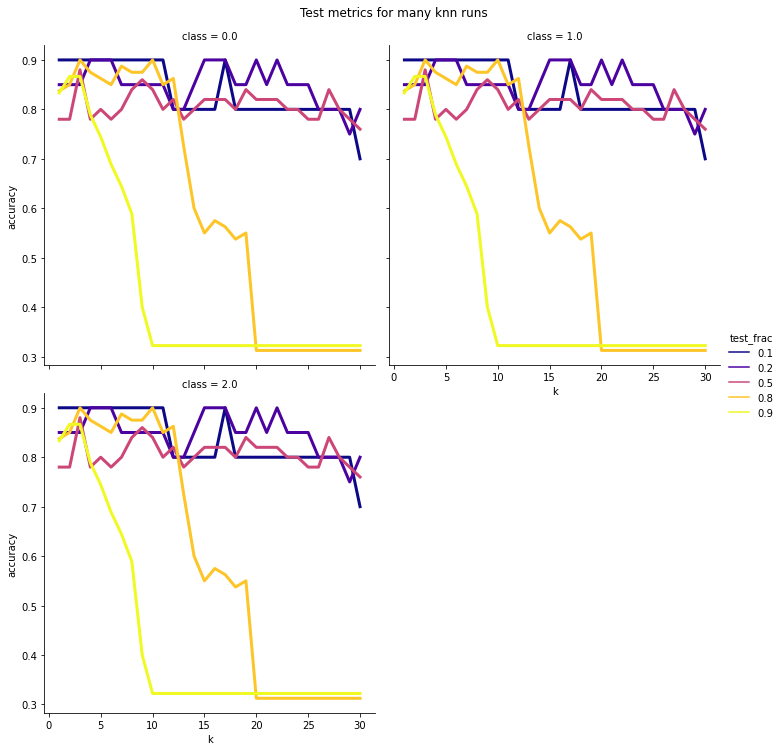

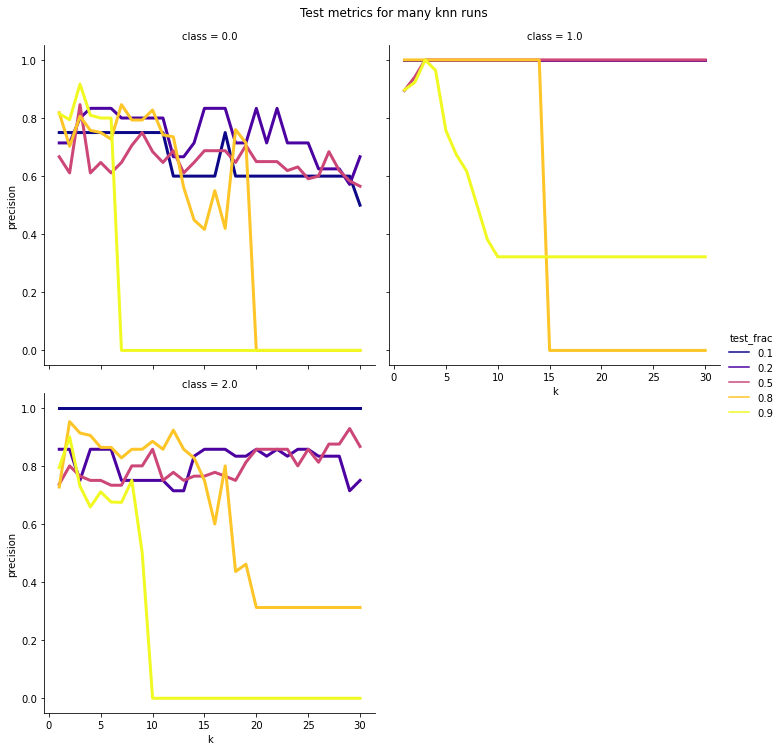

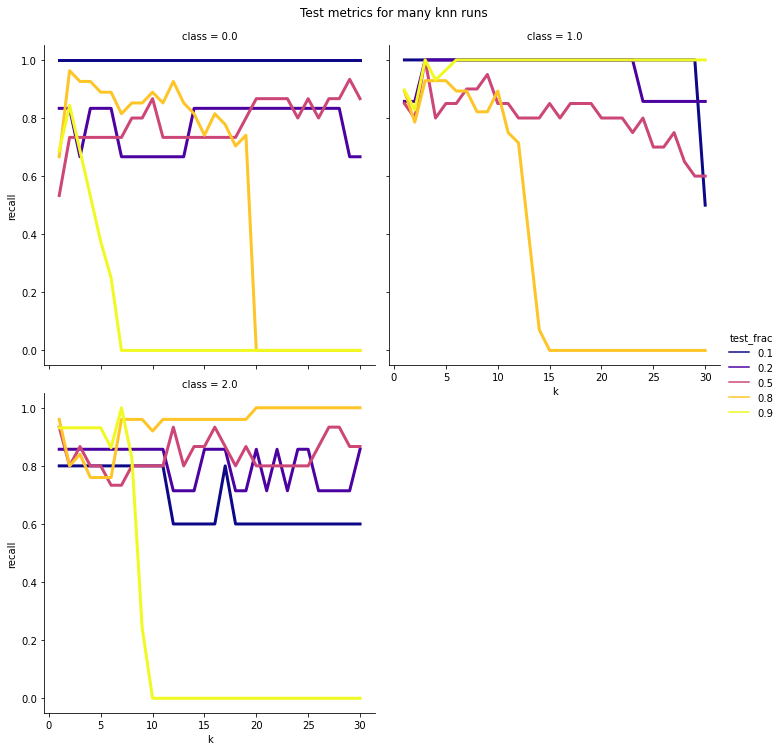

In [9]:
# plot test metrics for many knn runs
knsc.plot_multiclass_metrics_many(
    grid_params,
    acc, 
    precision,
    recall
)

In [10]:
### get grid param that gives best acc for all classes]
### experimental
test_metrics = np.hstack(
    [
        np.array(grid_params),
        acc.reshape(-1, 1),
        precision, 
        recall
    ]
)

# first get only indices where acc is maximal
test_metrics_paredown = test_metrics[
    np.where(test_metrics[:, 2] == test_metrics[:, 2].max())[0]
]

# first we will sum the multiclass precision and recall columns
test_metrics_paredown = np.hstack(
    [
        test_metrics_paredown[:, :3],
        np.sum(test_metrics_paredown[:, 3: 6], axis=1).reshape(-1, 1),
        np.sum(test_metrics_paredown[:, 6: 9], axis=1).reshape(-1, 1),
    ]
)
# then maybe we care about recall the next
test_metrics_paredown = test_metrics_paredown[
    np.where(test_metrics_paredown[:, 4] == test_metrics_paredown[:, 4].max())[0]
]
# then precision
test_metrics_paredown = test_metrics_paredown[
    np.where(test_metrics_paredown[:, 3] == test_metrics_paredown[:, 3].max())[0]
]
# then small k (more precicesly we want the supremum- the least upper bound)
# 10% of smallest represented class
k_upper = 0.1 * np.unique(y, return_counts=True)[1].min()
test_metrics_paredown = test_metrics_paredown[
    np.where(test_metrics_paredown[:, 1] <= k_upper)[0]
]
# supremum
test_metrics_paredown = test_metrics_paredown[-1, :]
test_frac, k = test_metrics_paredown[:2]
k = int(k)

test frac=0.1, k=3:
0.9 -- test accuracy
[0.75 1.   1.  ] -- test precision
[1.  1.  0.8] -- test recall



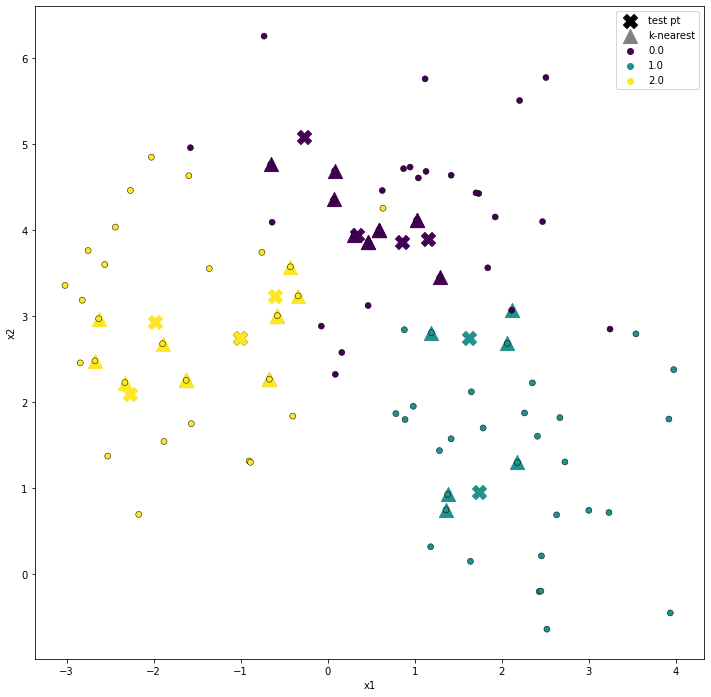

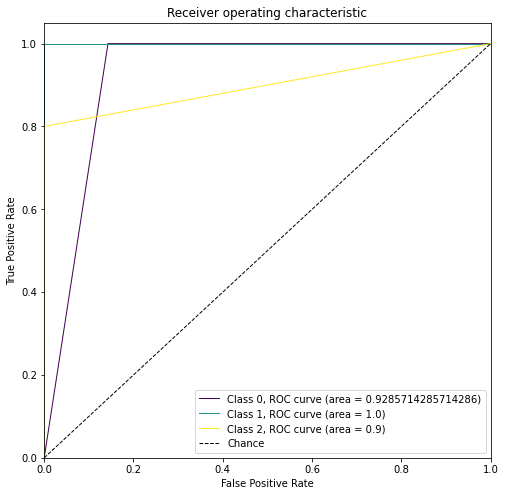

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=test_frac,
    random_state=73
)

kn_indices, kn_distances, kn_pts, y_pred = knsc.run_knn(
    X_train,
    X_test, 
    y_train,
    y_test,
    k=k
)

print(
    f'test frac={test_frac}, k={k}:\n'
    f'{skm.accuracy_score(y_test, y_pred)} -- test accuracy\n'
    f'{skm.precision_score(y_test, y_pred, average=None)} -- test precision\n'
    f'{skm.recall_score(y_test, y_pred, average=None)} -- test recall\n'
)

knsc.plot_test_pts_w_l2_circles(
    X_train,
    X_test,
    y_train,
    kn_indices,
    kn_distances,
    kn_pts,
    y_pred,
    circles=False
)

rocs = knsc.roc_auc_plot(y_test, y_pred)

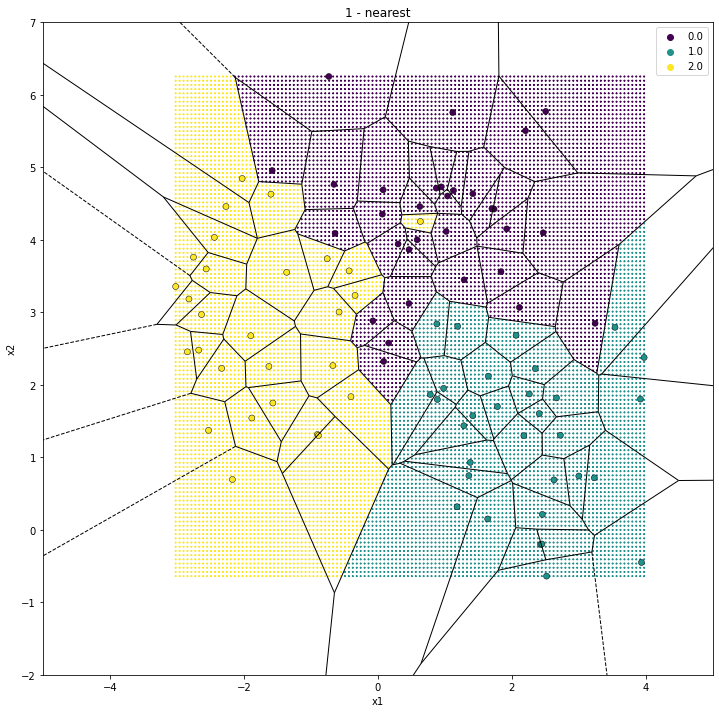

In [14]:
### show Voroni connection
vor = Voronoi(X_train)

N = 120
lattice = knsc.gen_X_test_lattice(X_train, N=N)
X_test_dense = np.column_stack((lattice[0].ravel(), lattice[1].ravel()))

(
    kn_indices_dense, 
    kn_distances_dense,
    kn_pts_dense,
    y_pred_dense
) = knsc.run_knn(
    X_train,
    X_test_dense, 
    y_train,
    y_test,
    k=1
)

knsc.plot_voroni_test(X_train, X_test_dense, y_train, y_pred_dense, vor, k=1)

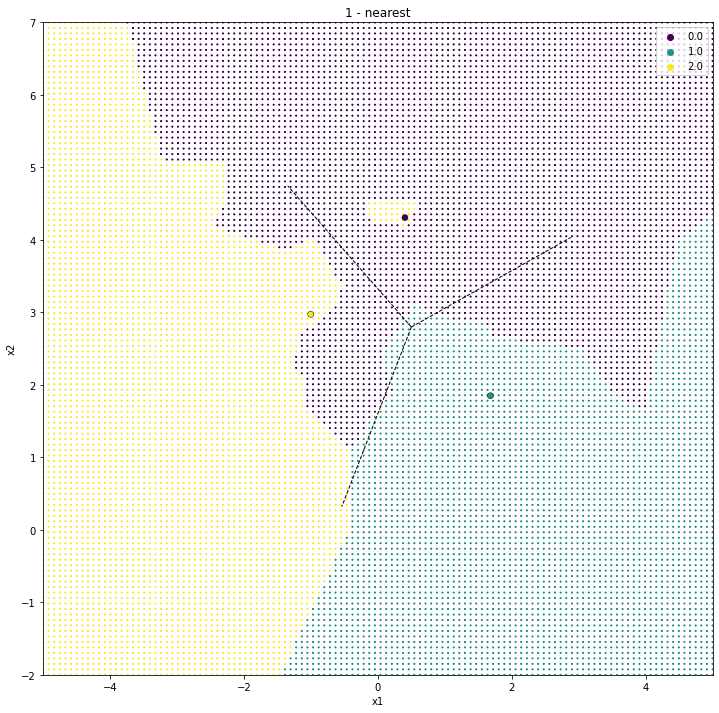

In [15]:
### for avg of X show decision boundary, like having very small train frac
X_avg = np.vstack(
    [np.mean(X_test[np.where(y_test == i)], axis=0) for i in np.unique(y_test)]
)
y_avg = np.unique(y_test)

vor_avg = Voronoi(X_avg)
lattice_avg = knsc.gen_X_test_lattice(
    X_avg,
    N=N,
    x1_bounds=[-5, 5],
    x2_bounds=[-2, 7]
)
X_avg_dense = np.column_stack((lattice_avg[0].ravel(), lattice_avg[1].ravel()))

(
    kn_indices_dense_avg,
    kn_distances_dense_avg,
    kn_pts_dense_avg, 
    y_pred_dense_avg
) = knsc.run_knn(
    X_train,
    X_avg, 
    y_train,
    y_avg,
    k=1
)

knsc.plot_voroni_test(X_avg, X_avg_dense, y_avg, y_pred_dense, vor_avg, k=1)

In [16]:
### knn on X_test_dense to compare against a knn on just avg pts
(
    kn_indices_extreme,
    kn_distances_extreme,
    kn_pts_extreme, 
    y_pred_extreme
) = knsc.run_knn(
    X_avg,
    X_test_dense, 
    y_avg,
    y_pred_dense,
    k=1
)

print(
    f'{skm.accuracy_score(y_pred_dense, y_pred_extreme)} -- test accuracy\n'
    f'{skm.precision_score(y_pred_dense, y_pred_extreme, average=None)} -- test precision\n'
    f'{skm.recall_score(y_pred_dense, y_pred_extreme, average=None)} -- test recall\n'
)

0.890625 -- test accuracy
[0.95279761 0.79545888 0.93812292] -- test precision
[0.7913559  0.99451336 0.90741113] -- test recall



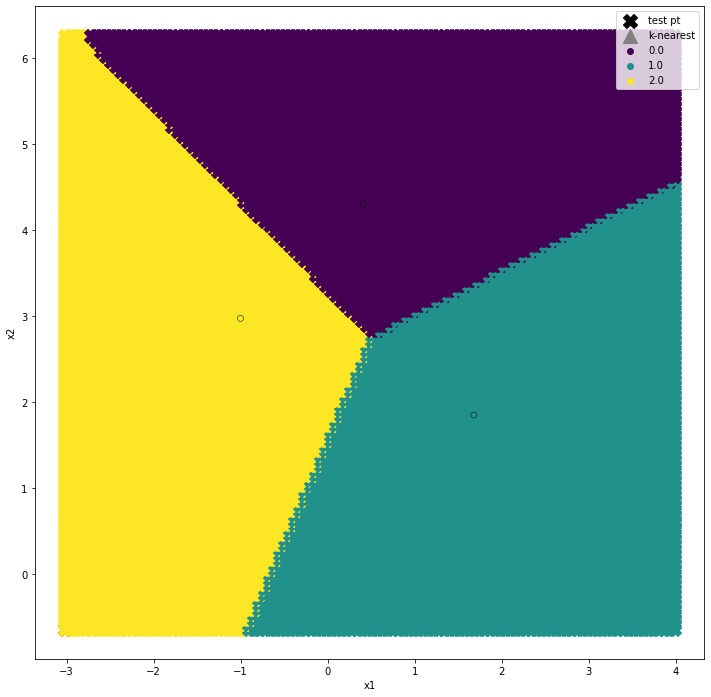

In [18]:
### TODO explore why looks very newton fractal like
knsc.plot_test_pts_w_l2_circles(
    X_avg,
    X_test_dense,
    y_avg,
    kn_indices_extreme,
    kn_distances_extreme,
    kn_pts_extreme,
    y_pred_extreme,
    circles=False
)

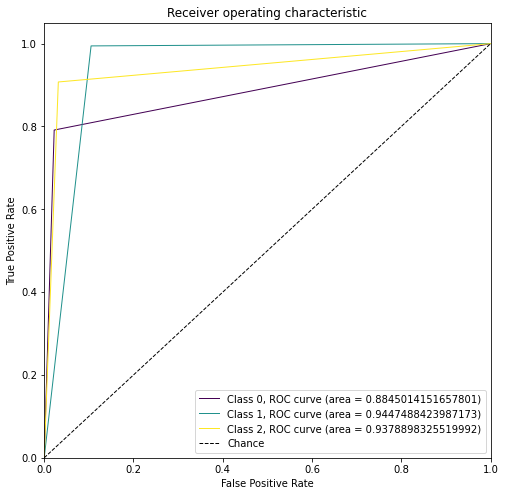

In [17]:
rocs = knsc.roc_auc_plot(y_pred_dense, y_pred_extreme)